## Mono/Di-derm phenotype: data analysis, processing, and visualization

#### 1. Read the train and test datasets and plot a histogram

In [12]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_diderm_data, pca_run_and_plot, tsne_plot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_filename_train = "../data_diderm/all_gene_annotations.training.tsv"
data_filename_test = "../data_diderm/all_gene_annotations.testing.tsv"
data_filename_all = "../data_diderm/all_gene_annotations.tsv"
y_filename = "../data_diderm/gold_standard1.tsv"


X_val_all, y_label_all, X_column_names = read_diderm_data(data_filename_all, y_filename, device) #{'Diderm': 0, 'Monoderm': 1}
X_val_train, y_label_train, X_column_names = read_diderm_data(data_filename_train, y_filename, device) #{'Diderm': 0, 'Monoderm': 1}
X_val_test, y_label_test, X_column_names = read_diderm_data(data_filename_test, y_filename, device) #{'Diderm': 0, 'Monoderm': 1}
print(f"{len(X_val_train)} train samples; {len(X_val_test)} test samples")
print(f"{len(X_val_train[0])} features")

741 train samples; 187 test samples
2665 features


In [13]:
num_mono = float(sum(y_label_all.cpu()))
num_di = float(len(y_label_all.cpu()) - num_mono)

print(f"Number of Monoderms = {num_mono}, which is {round(100*num_mono/(num_mono+num_di),2)} %")
print(f"Number of Diderms = {num_di}, which is {round(100*num_di/(num_mono+num_di),2)} %")

Number of Monoderms = 316.0, which is 34.05 %
Number of Diderms = 612.0, which is 65.95 %


Data after PCA reduction: (928, 20)
Explained variance ratio: [0.08478027 0.05232734 0.04322221 0.03318241 0.02698622 0.02266151
 0.01850149 0.01513025 0.01182622 0.01095009 0.0099926  0.0091507
 0.0084671  0.00764987 0.00704698 0.0068592  0.0064758  0.00620528
 0.00574958 0.00557994]
Total explained variance: 0.39274507565144895
Shape of the projected data = (928, 2)


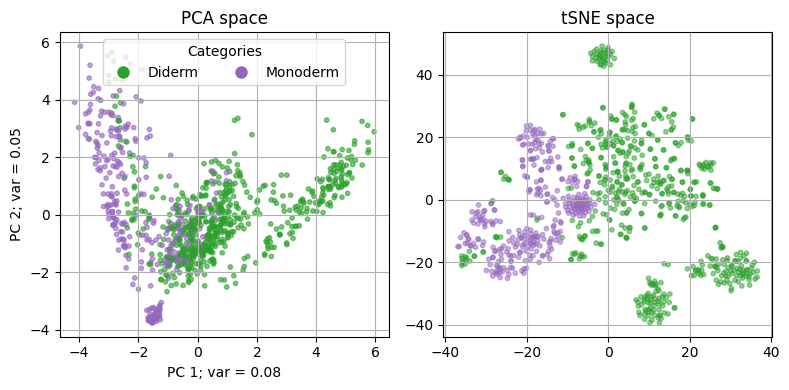

In [143]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = ["Diderm" if yi == 0 else "Monoderm" for yi in y_label_all]
pca_run_and_plot(X_val_all.cpu(), n_compon, y_label_all.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_all.cpu(), y_label_all.cpu(), colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [14]:
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

(baseline_test_accuracy, cv_accuracy) = xgboost_train_accur(X_val_train, y_label_train, X_val_test, y_label_test, device)
print(f"XGBoost baseline test accuracy (all features) = {baseline_test_accuracy}")
print(f"XGBoost cv_accuracy (all features) = {cv_accuracy}")

XGBoost baseline test accuracy (all features) = 0.9946524064171123
XGBoost cv_accuracy (all features) = 0.9946036640667513


In [15]:
# Presence only signal
X_train_numpy_pres_only = torch.tensor((X_val_train.cpu().numpy() > 0).astype(int))
X_test_numpy_pres_only = torch.tensor((X_val_test.cpu().numpy() > 0).astype(int))

(baseline_test_accuracy, cv_accuracy) = xgboost_train_accur(X_train_numpy_pres_only, y_label_train, X_test_numpy_pres_only, y_label_test, device)
print(f"XGBoost baseline test accuracy (all features) = {baseline_test_accuracy}")
print(f"XGBoost cv_accuracy (all features) = {cv_accuracy}")        

XGBoost baseline test accuracy (all features) = 0.9946524064171123
XGBoost cv_accuracy (all features) = 0.9959550154181027


In [16]:
X_train_np = np.array(X_val_train.cpu())
X_train_transposed = X_train_np.T

## Mutual Information

In [65]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

In [66]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0795', 'COG0763', 'COG0767', 'COG1127', 'COG1519', 'COG1212', 'COG1663', 'COG0854', 'COG0774', 'COG4783']


In [67]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

Data after PCA reduction: (741, 5)
Explained variance ratio: [0.6174751  0.10979746 0.08409678 0.05290091 0.04448936]
Total explained variance: 0.9087596051394939
Shape of the projected data = (741, 2)


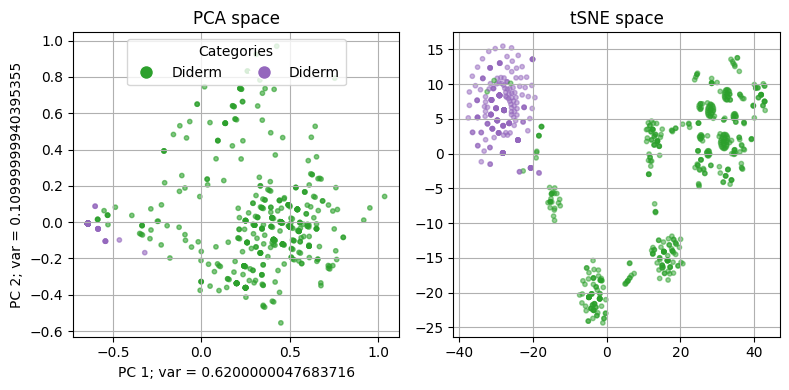

In [69]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()


In [86]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, baseline_test_accuracy, feat_step, device, feat_removal)       

In [87]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, baseline_test_accuracy, feat_step, device, feat_removal)       

In [88]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

0.9514511155450753
0.9090909090909091


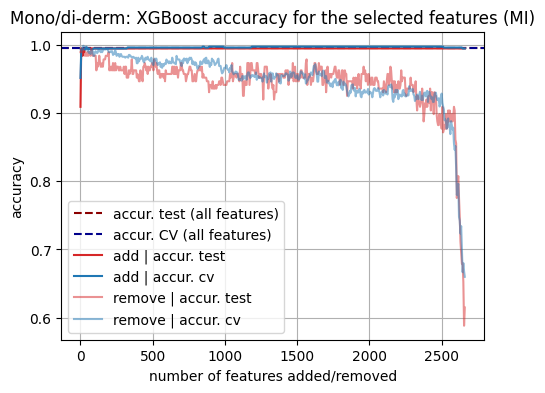

In [89]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axhline(y=baseline_test_accuracy, color='darkred', linestyle='--', linewidth=1.5, label='accur. test (all features)')
plt.axhline(y=cv_accuracy, color='darkblue', linestyle='--', linewidth=1.5, label='accur. CV (all features)')

plt.plot(num_feat, test_accur_arr, c = "tab:red", label = "add | accur. test")
plt.plot(num_feat, cv_accur_arr, c = "tab:blue", label = "add | accur. cv")

plt.plot(num_feat, test_accur_arr_rem, c = "tab:red", label = "remove | accur. test", alpha = 0.5)
plt.plot(num_feat, cv_accur_arr_rem, c = "tab:blue", label = "remove | accur. cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("accuracy")
plt.title("Mono/di-derm: XGBoost accuracy for the selected features (MI)")
plt.grid()
plt.legend()

## Random Forest

Feature importances: [0.00014171 0.0001595  0.00064325 ... 0.         0.         0.        ]
2665
Original feature count: 2665, Selected feature count: 313


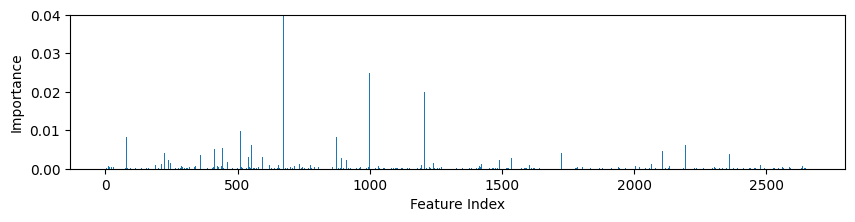

In [90]:
from feature_selection.feature_selection_utils import random_forest_features
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

In [91]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG1127', 'COG0767', 'COG0763', 'COG1519', 'COG0795', 'COG4783', 'COG1663', 'COG1461', 'COG1212', 'COG1995']


In [92]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (741, 5)
Explained variance ratio: [0.5873019  0.11553724 0.09244855 0.05412376 0.04828222]
Total explained variance: 0.897693682461977
Shape of the projected data = (741, 2)


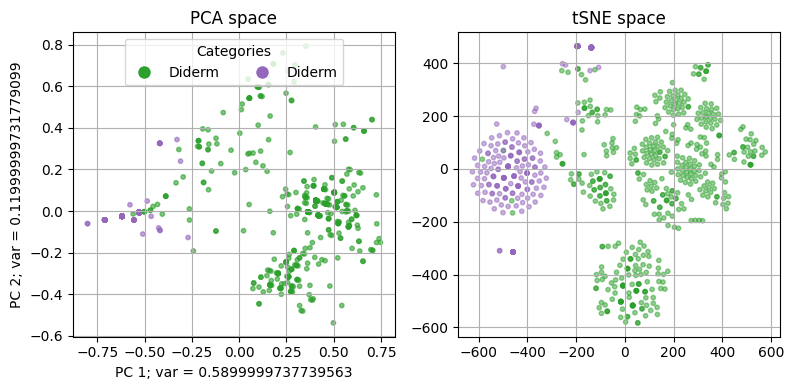

In [93]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [94]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, baseline_test_accuracy, feat_step, device, feat_removal)       

In [95]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

0.9257028840921459
0.893048128342246


In [96]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, baseline_test_accuracy, feat_step, device, feat_removal)       

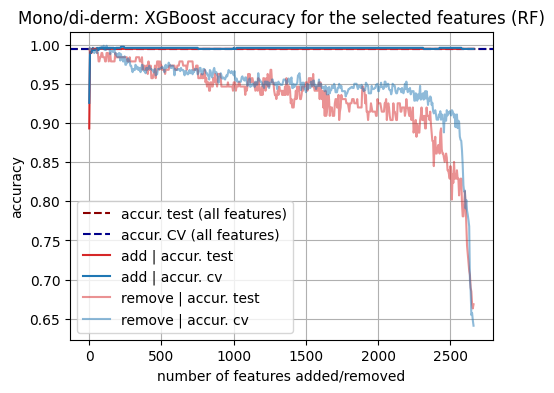

In [97]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axhline(y=baseline_test_accuracy, color='darkred', linestyle='--', linewidth=1.5, label='accur. test (all features)')
plt.axhline(y=cv_accuracy, color='darkblue', linestyle='--', linewidth=1.5, label='accur. CV (all features)')

plt.plot(num_feat, test_accur_arr, c = "tab:red", label = "add | accur. test")
plt.plot(num_feat, cv_accur_arr, c = "tab:blue", label = "add | accur. cv")

plt.plot(num_feat, test_accur_arr_rem, c = "tab:red", label = "remove | accur. test", alpha = 0.5)
plt.plot(num_feat, cv_accur_arr_rem, c = "tab:blue", label = "remove | accur. cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("accuracy")
plt.title("Mono/di-derm: XGBoost accuracy for the selected features (RF)")
plt.grid()
plt.legend()

## Feature comparison

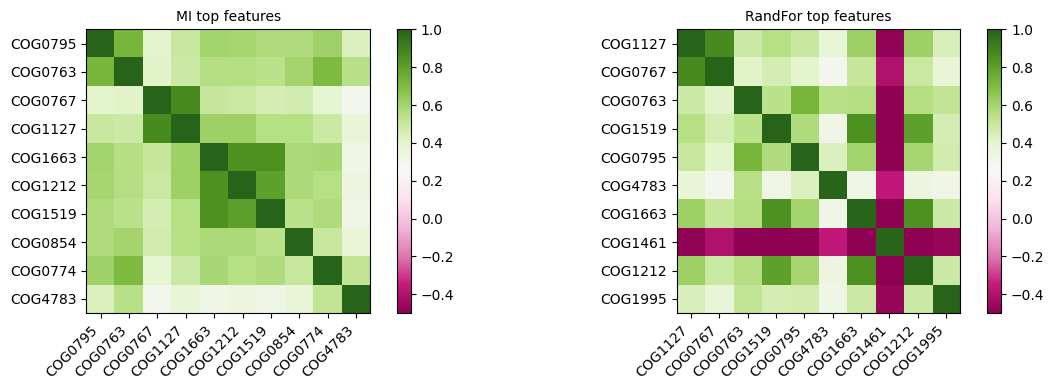

In [46]:
plt.figure(figsize=(12, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for mean_var top features
plt.subplot(1, 2, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for MI top features
plt.subplot(1, 2, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandFor top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.show()



## SHAP values

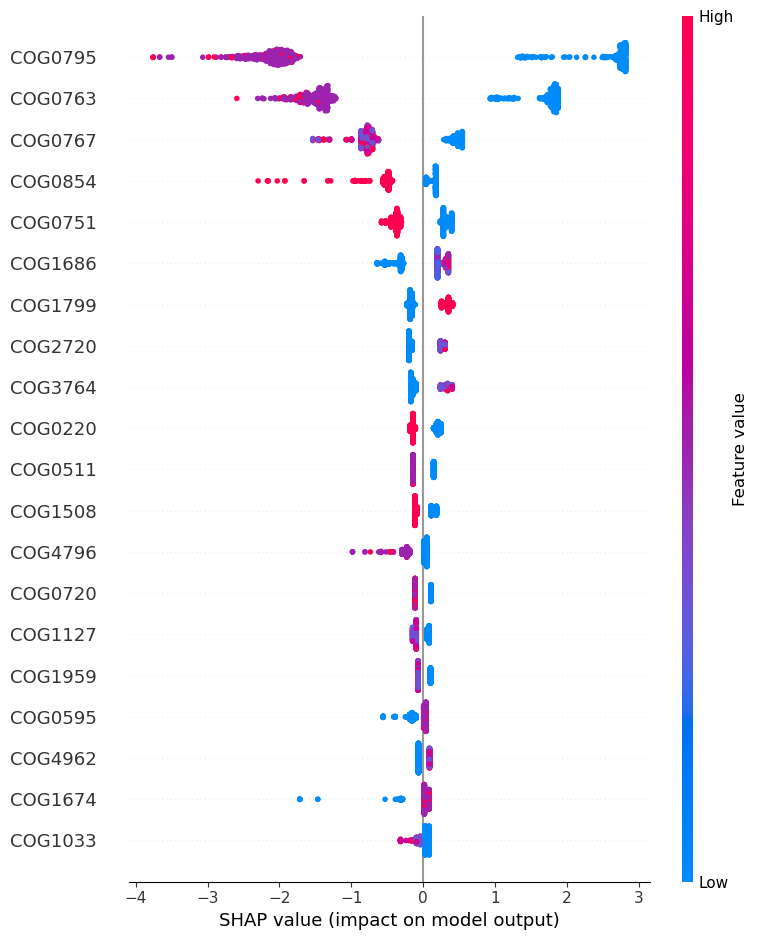

In [18]:
# Create SHAP Explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for training & test set
shap_values_train = explainer.shap_values(X_val_train)
shap_values_test = explainer.shap_values(X_val_test)

# Visualize feature importance
shap.summary_plot(shap_values_train, X_val_train, feature_names=X_column_names_tr)  # Summary plot

In [19]:
shap_df = pd.DataFrame(shap_values_train, columns=[f"Feature_{i}" for i in range(X_val_train.shape[1])])

average_shaps = np.mean(shap_values_train, axis=0)

# Optionally, pair it with feature names if available
feature_names = ["Feature_0", "Feature_1", "Feature_2", "Feature_3"]
average_shaps_df = pd.DataFrame(average_shaps, columns=["Average SHAP Value"], index=X_column_names_tr)


Text(0.5, 1.0, 'Mono/di-derm: average SHAP value for the top 70 features')

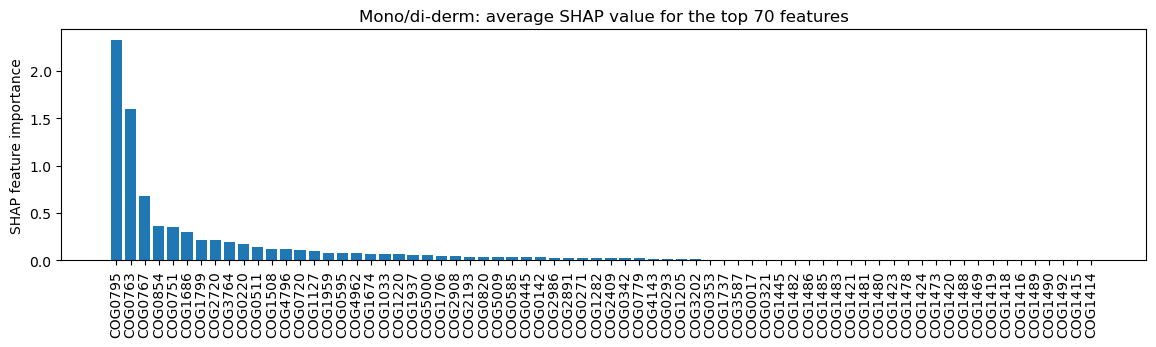

In [20]:
# Extracting top N 
N=70
abs_shap_values = np.abs(shap_values_train)

# Step 2: Calculate the mean absolute SHAP value for each feature across all samples
mean_abs_shap_values = np.mean(abs_shap_values, axis=0)

# Step 3: Sort the features based on the mean absolute SHAP values
sorted_indices = np.argsort(mean_abs_shap_values)[::-1]  # Sorting in descending order
sorted_feature_names = [X_column_names_tr[i] for i in sorted_indices]

top_n_features = [f"{i}" for i in sorted_feature_names[:N]]

# Step 6: Display the top N features and their average SHAP values
top_n_shap_values = mean_abs_shap_values[sorted_indices[:N]]
top_n_df = pd.DataFrame({
    'Feature': top_n_features,
    'Average SHAP Value': top_n_shap_values
})

plt.figure(figsize=(14, 3))
plt.bar(range(len(top_n_shap_values)),top_n_shap_values)
plt.xticks(range(len(top_n_features)), top_n_features, rotation=90);
plt.ylabel("SHAP feature importance")
plt.title(f"Mono/di-derm: average SHAP value for the top {N} features")

In [21]:
import pandas as pd

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_n_features[:len(top_N_names_by_rand_forest)]
}

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

NameError: name 'top_N_names_by_mi' is not defined

In [22]:
import shap
import xgboost as xgb
import numpy as np

# Train your model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Create SHAP Explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values for training & test set
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

# Visualize feature importance
shap.summary_plot(shap_values_train, X_train)  # Summary plot


NameError: name 'X_train' is not defined

In [24]:
feat_step = 100
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_indices, baseline_test_accuracy, feat_step, device, feat_removal)       

In [25]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_indices, baseline_test_accuracy, feat_step, device, feat_removal)       

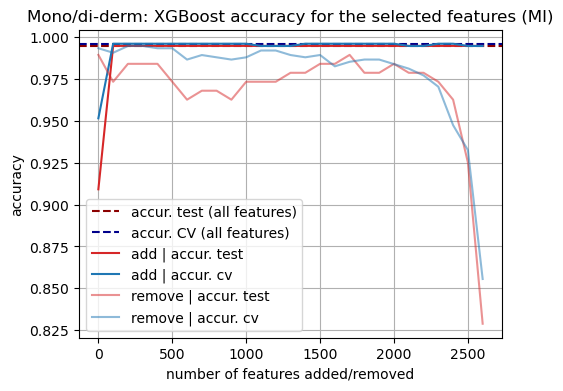

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axhline(y=baseline_test_accuracy, color='darkred', linestyle='--', linewidth=1.5, label='accur. test (all features)')
plt.axhline(y=cv_accuracy, color='darkblue', linestyle='--', linewidth=1.5, label='accur. CV (all features)')

plt.plot(num_feat, test_accur_arr, c = "tab:red", label = "add | accur. test")
plt.plot(num_feat, cv_accur_arr, c = "tab:blue", label = "add | accur. cv")

plt.plot(num_feat, test_accur_arr_rem, c = "tab:red", label = "remove | accur. test", alpha = 0.5)
plt.plot(num_feat, cv_accur_arr_rem, c = "tab:blue", label = "remove | accur. cv", alpha = 0.5)

plt.xlabel("number of features added/removed")
plt.ylabel("accuracy")
plt.title("Mono/di-derm: XGBoost accuracy for the selected features (MI)")
plt.grid()
plt.legend()